# Imports

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

import graphviz
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import cycle
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

import joblib

import psycopg2
from sqlalchemy import create_engine

# Metrics

In [3]:
def print_metrics(y_train, y_pred_train, y_test, y_pred_test, cv_scores):
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    F1_score_test = f1_score(y_test, y_pred_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    F1_score_train = f1_score(y_train, y_pred_train)
    
    metrics = {'Test': [accuracy_test, precision_test, recall_test, F1_score_test], 
               'Train': [accuracy_train, precision_train, recall_train, F1_score_train],
               'CV': [cv_scores['accuracy'], cv_scores['precision'], cv_scores['recall'], cv_scores['f1']]}
    metrics_df = pd.DataFrame(data=metrics, index = ['accuracy', 'precision', 'recall', 'F1'])
    
    return metrics_df

In [4]:
def get_summing_metrics(scores_dict):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    scores_dict = {key: [value[metric] for metric in scores] for key, value in scores_dict.items()}
    
    return pd.DataFrame(data=scores_dict, index=scores)

In [5]:
def plot_confusion_matrix(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Confusion Matrix')
    y_pred = estimator.predict(X)
    ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax, colorbar=False)
    return ax

def plot_auc_roc_proba(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('ROC Curve')
    y_pred_proba = estimator.predict_proba(X)[::,1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    roc_auc = roc_auc_score(y, y_pred_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Current estimator').plot(ax=ax)
    ax.plot([0,1], [0,1], 'r--', label='Random guess (AUC = 0.5)')
    ax.legend(loc=4)
    return ax

def plot_precision_recall_curve(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Precision-Recall Curve')
    y_pred_proba = estimator.predict_proba(X)[::,1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax)
    return ax

def plot_learning_curve(estimator, X, y, cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Learning Curve')
    ax.set_xlabel("Samples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-validation score")
    ax.legend(loc=4)
    return ax

In [6]:
def plot_graphs(estimator, X_train, X_test, y_train, y_test, cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    plot_confusion_matrix(estimator, X_test, y_test, ax=ax1)
    plot_auc_roc_proba(estimator, X_test, y_test, ax=ax2)
    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax3)
    plot_learning_curve(estimator, X_train, y_train, cv, ax=ax4)
    
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

## Other

In [7]:
def get_cv_scores(estimator, X, y, cv=5):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    cv_scores = {key.lstrip('test_'): np.mean(value) for key, value in cross_validate(estimator, X, y, cv=cv, scoring=scores).items()}
    cv_scores = {key: value for key, value in cv_scores.items() if key in scores}
    return cv_scores

# Dataset

In [8]:
df = pd.read_csv('credit_history.csv')
df

,age,month_income,employment_length,home_ownership,loan_intent,loan_amount,loan_interest_rate,previous_loans,previous_default,loan_grade,loan_status
0,-0.923078,-0.130141,-0.189187,-0.896640,0.374120,4.044389,1.623551,-0.691031,2.160802,-1.525972,0
1,-1.085220,-1.449286,0.062299,2.252578,0.883165,-1.362025,0.040752,-0.938791,-0.462791,0.187939,1
2,-0.436650,-1.449286,-0.943643,0.677969,-0.922686,-0.646470,0.601867,-0.691031,-0.462791,-0.669017,0
3,-0.760935,0.043431,-0.189187,-0.896640,-0.922686,4.044389,1.367319,-0.938791,-0.462791,-0.669017,0
4,-0.598793,-0.252976,0.816754,-0.896640,-0.922686,4.044389,1.055949,-0.443271,2.160802,-0.669017,0
...,...,...,...,...,...,...,...,...,...,...,...
32269,4.751909,-0.290361,-0.943643,0.677969,0.374120,-0.598767,0.695927,5.998481,-0.462791,-0.669017,1
32270,4.265482,1.498764,-0.189187,0.677969,0.374120,1.281553,-1.143105,3.273124,-0.462791,1.044894,1
32271,6.049049,0.323816,-0.440672,-0.896640,-0.829432,4.044389,-0.007900,5.502961,-0.462791,0.187939,0
32272,4.589767,2.299864,0.062299,0.677969,0.374120,0.864146,0.151029,5.007442,-0.462791,0.187939,1


## Data splitting

In [9]:
target_feature = 'loan_status'
features = list(df.columns)
features.remove(target_feature)

In [10]:
X, y = df[features], df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
X_train.shape, X_test.shape

((24205, 10), (8069, 10))

In [12]:
y_train.shape, y_test.shape

((24205,), (8069,))

# Models

## Logistic Regression

### First model

In [13]:
log_clf = LogisticRegression(random_state=42)
log_clf = log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_test = log_clf.predict(X_test)
cv_scores = get_cv_scores(log_clf, X_train, y_train, cv=5)

In [14]:
print_metrics(y_train, y_pred_train, y_test, y_pred_test, cv_scores)

,Test,Train,CV
accuracy,0.850911,0.844082,0.844082
precision,0.870834,0.860437,0.860477
recall,0.953037,0.954120,0.954067
F1,0.910083,0.904860,0.904855


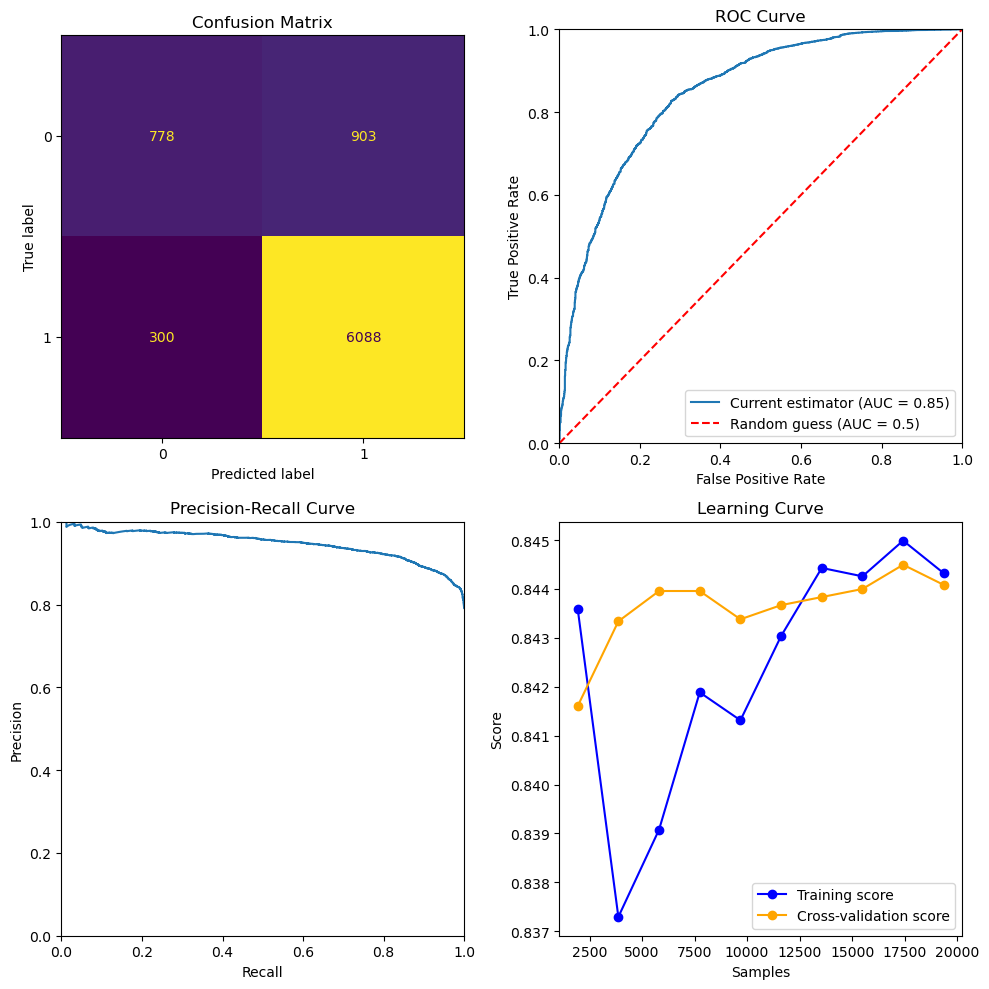

In [15]:
plot_graphs(log_clf, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

### GridSearchCV

In [16]:
parameters = {
    'C': np.linspace(0.01, 30, 25),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
log_regression = LogisticRegression(max_iter=5000, random_state=42)
grid_search = GridSearchCV(log_regression, parameters, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

best_log_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [17]:
y_pred_train = best_log_model.predict(X_train)
y_pred_test = best_log_model.predict(X_test)
best_log_cv_scores = get_cv_scores(best_log_model, X_train, y_train, cv=5)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_log_cv_scores)

,Test,Train,CV
accuracy,0.848680,0.840983,0.840405
precision,0.865572,0.854711,0.853312
recall,0.957577,0.958267,0.959596
F1,0.909253,0.903531,0.903335


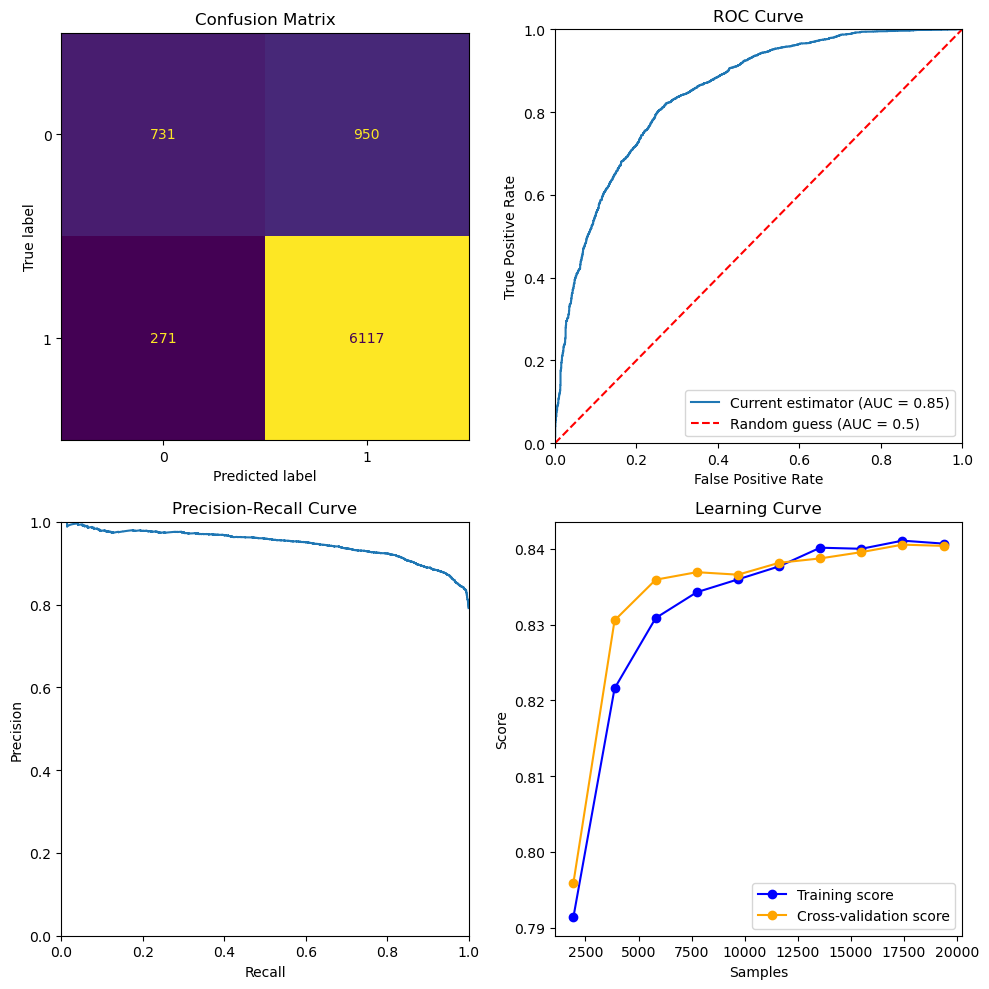

In [18]:
plot_graphs(best_log_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

## Decision Tree

### First model

In [19]:
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf = tree_clf.fit(X_train, y_train)

y_pred_train = tree_clf.predict(X_train)
y_pred_test = tree_clf.predict(X_test)
cv_scores = get_cv_scores(tree_clf, X_train, y_train, cv=10)

In [20]:
print_metrics(y_train, y_pred_train, y_test, y_pred_test, cv_scores)

,Test,Train,CV
accuracy,0.926013,0.935964,0.920224
precision,0.926373,0.928841,0.919584
recall,0.984815,0.993727,0.983360
F1,0.954701,0.960189,0.950399


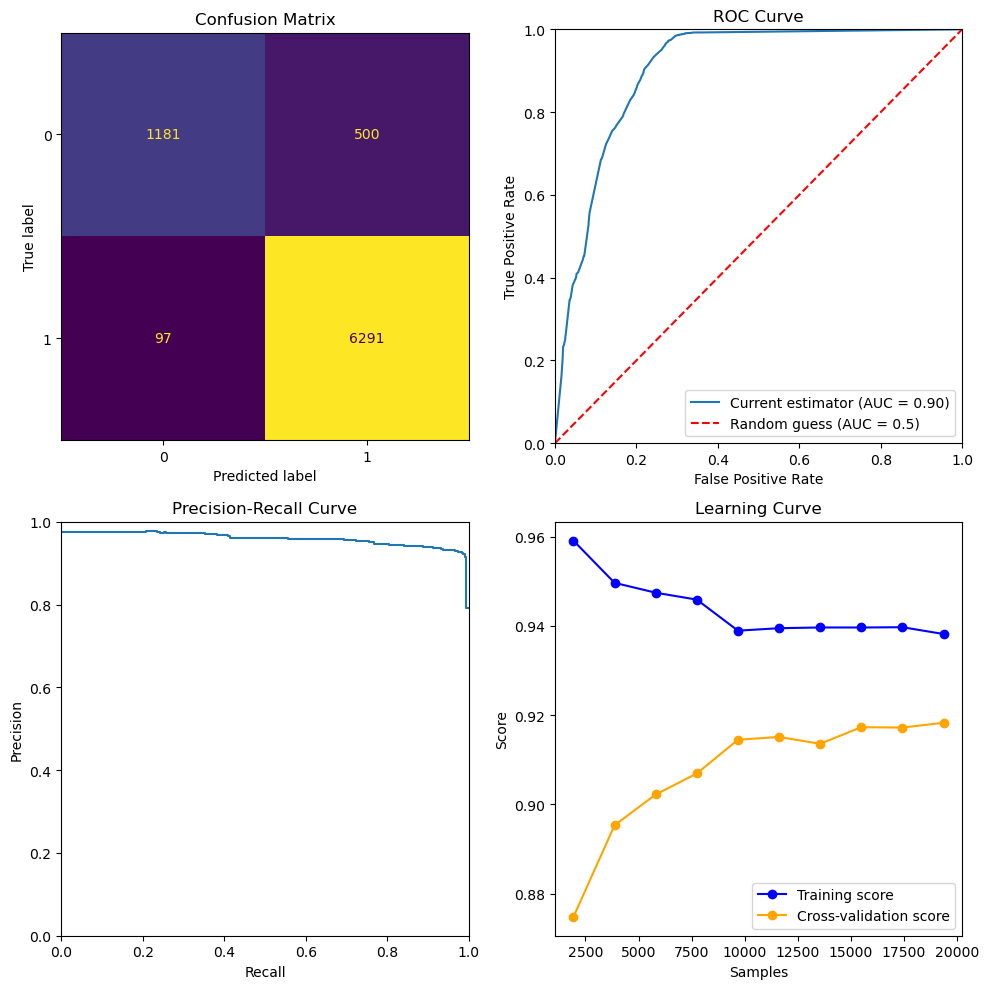

In [21]:
plot_graphs(tree_clf, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

### GridSearchCV

In [22]:
parameters = {
    'max_depth': [None, 5, 7, 10, 13, 15, 20],
    'min_samples_split': [1, 2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}
decision_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(decision_tree, parameters, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 1}


In [23]:
y_pred_train = best_tree_model.predict(X_train)
y_pred_test = best_tree_model.predict(X_test)
best_tree_cv_scores = get_cv_scores(best_tree_model, X_train, y_train, cv=10)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_tree_cv_scores)

,Test,Train,CV
accuracy,0.924154,0.925346,0.918447
precision,0.925081,0.921764,0.917253
recall,0.983876,0.987772,0.983838
F1,0.953573,0.953627,0.949374


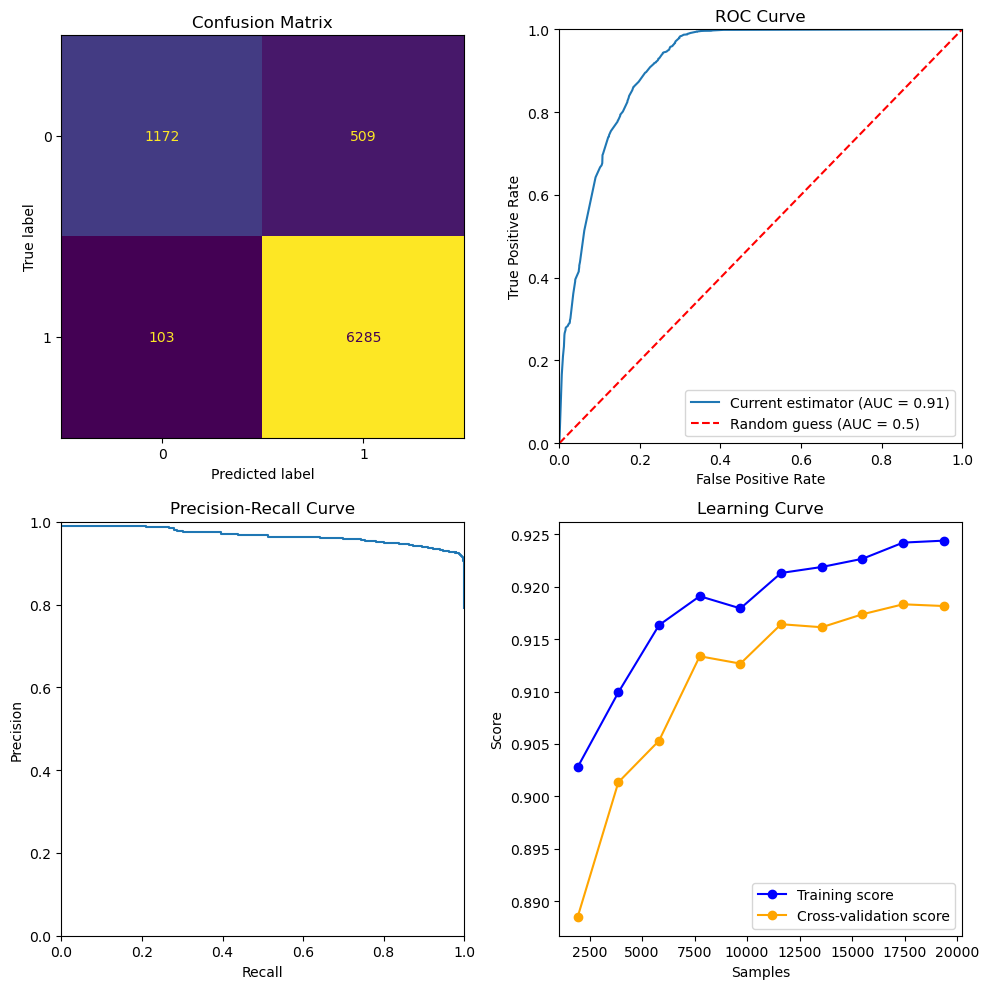

In [24]:
plot_graphs(best_tree_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

## Random Forest

In [25]:
forest_clf = RandomForestClassifier(n_estimators=600, max_depth=15, max_features=15, random_state=42)
forest_clf.fit(X_train, y_train)

y_pred_train = forest_clf.predict(X_train)
y_pred_test = forest_clf.predict(X_test)
forest_cv_scores = get_cv_scores(forest_clf, X_train, y_train, cv=5)

In [26]:
print_metrics(y_train, y_pred_train, y_test, y_pred_test, forest_cv_scores)

,Test,Train,CV
accuracy,0.932705,0.964677,0.927412
precision,0.930222,0.956568,0.922593
recall,0.989198,0.999947,0.989633
F1,0.958804,0.977777,0.954936


In [27]:
# plot_graphs(forest_clf, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

## Gradient boosting

### First model

In [28]:
gbm_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=42)
gbm_clf.fit(X_train, y_train)

y_pred_train = gbm_clf.predict(X_train)
y_pred_test = gbm_clf.predict(X_test)
gbm_cv_scores = get_cv_scores(gbm_clf, X_train, y_train, cv=5)

In [29]:
print_metrics(y_train, y_pred_train, y_test, y_pred_test, gbm_cv_scores)

,Test,Train,CV
accuracy,0.874582,0.864945,0.864863
precision,0.865217,0.853221,0.853376
recall,0.996869,0.997873,0.997501
F1,0.926389,0.919895,0.919825


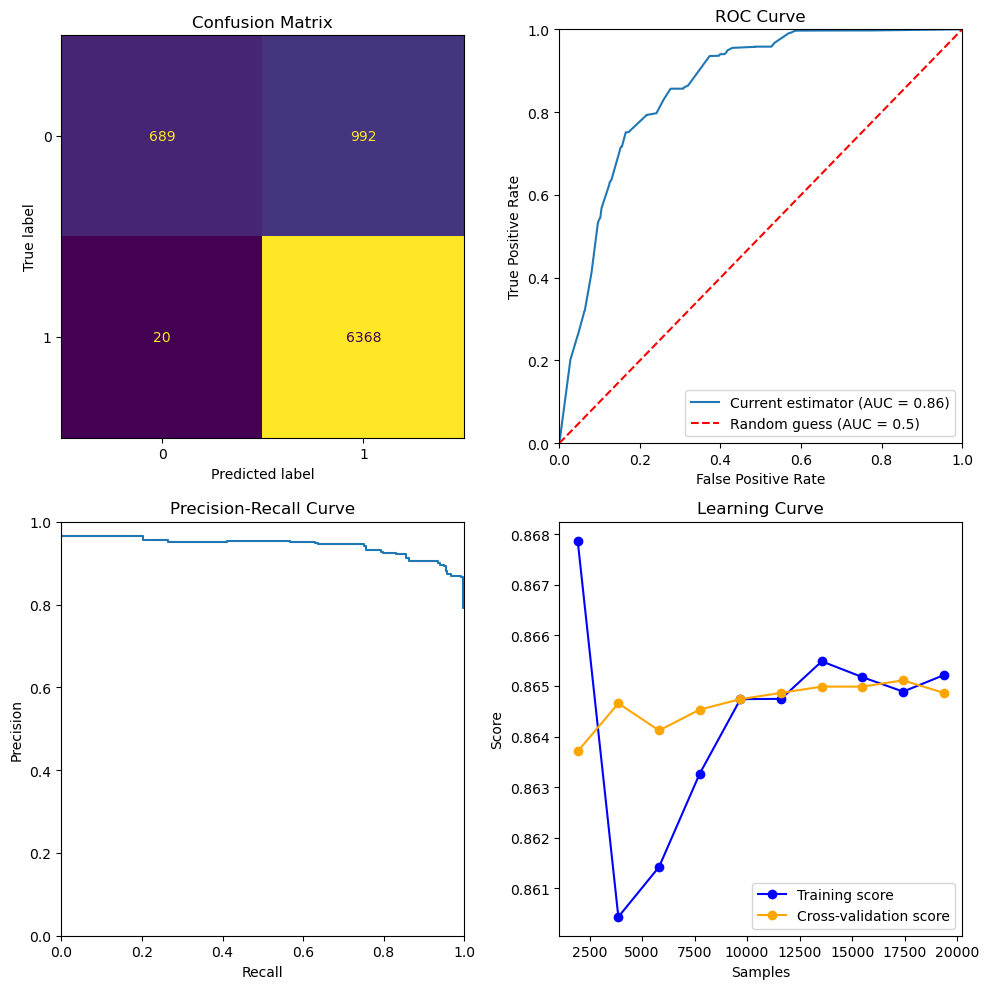

In [30]:
plot_graphs(gbm_clf, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

### GridSearch

In [31]:
parameters = {
    'n_estimators': [10, 13, 15, 20, 25, 35, 50],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}
gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbm, parameters, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_gbm_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


In [32]:
y_pred_train = best_gbm_model.predict(X_train)
y_pred_test = best_gbm_model.predict(X_test)
best_gbm_cv_scores = get_cv_scores(best_gbm_model, X_train, y_train, cv=10)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_tree_cv_scores)

,Test,Train,CV
accuracy,0.930970,0.937823,0.918447
precision,0.930332,0.931697,0.917253
recall,0.986694,0.992770,0.983838
F1,0.957684,0.961264,0.949374


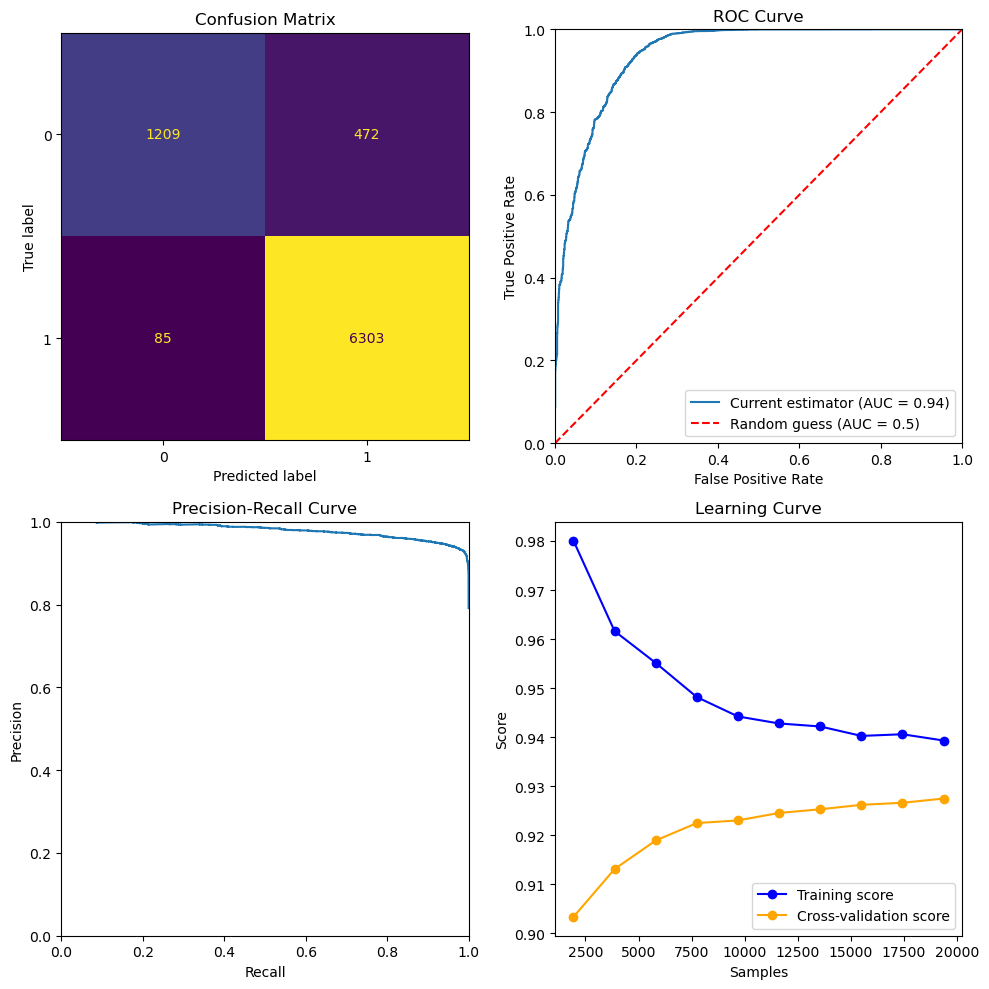

In [33]:
plot_graphs(best_gbm_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

# Summing

In [42]:
sm = get_summing_metrics({'Logistic regression': best_log_cv_scores, 'Decision tree': best_tree_cv_scores, 'Random forest': forest_cv_scores, 'Gradient boosting machines': best_gbm_cv_scores})
sm

,Logistic regression,Decision tree,Random forest,Gradient boosting machines
accuracy,0.840405,0.918447,0.927412,0.926834
precision,0.853312,0.917253,0.922593,0.924142
recall,0.959596,0.983838,0.989633,0.986869
f1,0.903335,0.949374,0.954936,0.954471


In [43]:
sm.to_json('scores.json', orient='index')

# Saving models

In [36]:
joblib.dump(best_log_model, 'logistic_regression.joblib')
joblib.dump(best_tree_model, 'decision_tree.joblib')
joblib.dump(forest_clf, 'random_forest.joblib')
joblib.dump(best_gbm_model, 'gradient_boosting_machines.joblib')

['gradient_boosting_machines.joblib']